# Загрузка Order book из CSV

In [1]:
import pandas as pd
from sqlalchemy import create_engine
import numpy as np
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn import metrics
#from sklearn.cross_validation import cross_val_score
#from sklearn.cross_validation import cross_val_predict
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
from alex.database import Database
from pprint import pprint
from statsmodels.tsa.stattools import adfuller # Расширенный тест Дики-Фуллера
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot

### Скоростная загрузка с диска, из заархивированного CSV-файла

In [27]:
# результат выполнения запроса:
# select * from tvf_get_order_book_snapshots(2880) where exchange='binance' and pair='ETH/USDT' # запрос на 20 минут
#order = pd.read_csv('tvf_get_order_book_snapshots 15.09.2018-01.10.2018.zip', index_col='dt')

In [92]:
# загрузка истории
# 15 секунд
db = Database()
sql_history = f"select * from v_history where exchange='bittrex' and pair='ETH/USDT' and dt>'2018-08-1'"
df_history = db.query(sql_history)
df_history.set_index('dt', inplace=True)

In [93]:
df_history.shape

(124183, 11)

In [94]:
df_history.sort_values('dt').head()

,rownum,id_ex_pair,exchange,pair,price,amount,type,side,id,location,insert_date
dt,,,,,,,,,,,
2018-09-07 01:45:39,NaN,72,bittrex,ETH/USDT,225.0,0.013560,limit,sell,NaN,disk,2018-09-07 02:22:01.2233333
2018-09-07 01:46:01,NaN,72,bittrex,ETH/USDT,225.0,0.020137,limit,sell,NaN,disk,2018-09-07 02:22:01.2233333
2018-09-07 01:46:27,NaN,72,bittrex,ETH/USDT,225.0,0.002168,limit,sell,NaN,disk,2018-09-07 02:22:01.2233333
2018-09-07 01:46:27,NaN,72,bittrex,ETH/USDT,225.0,0.007900,limit,sell,NaN,disk,2018-09-07 02:22:01.2233333
2018-09-07 01:46:37,NaN,72,bittrex,ETH/USDT,225.0,0.015102,limit,sell,NaN,disk,2018-09-07 02:22:01.2233333


In [95]:
#перевод в нужные интервалы
interval = 60 # minutes

#df = history[['price', 'amount']].resample(str(interval)+'min').ohlc()
hist = df_history[['price', 'amount']].resample(str(interval)+'min').mean()
hist.shape

(1191, 2)

In [96]:
hist.fillna(method='ffill', inplace=True)

In [97]:
hist.head()

,price,amount
dt,,
2018-09-07 01:00:00,225.541936,0.479665
2018-09-07 02:00:00,229.235874,2.702331
2018-09-07 03:00:00,229.235874,2.702331
2018-09-07 04:00:00,229.235874,2.702331
2018-09-07 05:00:00,229.235874,2.702331


In [98]:
acf(hist[1658:len(hist)].price.diff().dropna(), nlags=1)[1]

C:\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:354: RuntimeWarning: Mean of empty slice.
  xo = x - x.mean()
C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


ValueError: negative dimensions are not allowed

In [99]:
mylist=[]
for i in range(1, len(hist)):
    a = acf(hist[i:len(hist)].price.diff().dropna(), nlags=1)[1]
    mylist.append(a)
    print (i, a) 
mylist    

1 0.16572414363179377
2 0.16572407991962493
3 0.16572401609998844
4 0.16572395217261204
5 0.1657238881372227
6 0.16572382399354646
7 0.16572375974130854
8 0.16572369538023307
9 0.16572363091004294
10 0.16574279541998654
11 0.16303647029605361
12 0.16059716896021048
13 0.1611168883122744
14 0.1611168741550242
15 0.16111685997365172
16 0.16111684576809537
17 0.161116831538293
18 0.16111681728418273
19 0.16111680300570203
20 0.16111678870278845
21 0.16111677437537916
22 0.16111676002341133
23 0.16111674564682163
24 0.1611167312455465
25 0.16111671681952258
26 0.16111670236868597
27 0.16111668789297245
28 0.16111667339231775
29 0.16111665886665757
30 0.1611166443159269
31 0.161116629740061
32 0.16111661513899458
33 0.16111213881909847
34 0.16137442146276235
35 0.16137558137068406
36 0.16137783530343225
37 0.16121898721138944
38 0.16125036213027655
39 0.16125034663699236
40 0.16125033111673492
41 0.161253887554108
42 0.1613672602525767
43 0.16136724944954167
44 0.16136723862763336
45 0.1613

619 0.2507623035103469
620 0.25081175348899315
621 0.2506623057008247
622 0.2510958348476362
623 0.2516114234970572
624 0.25211375667600655
625 0.25124358095201954
626 0.25269598447179464
627 0.25381658259368106
628 0.2469947541717573
629 0.25060041321139387
630 0.24999969950920045
631 0.2523019620758108
632 0.2530457044625788
633 0.25329403129780653
634 0.254458544684523
635 0.2531932239759776
636 0.25398184143162394
637 0.25391526536257863
638 0.25384485556939546
639 0.2545679577410904
640 0.25645919031066916
641 0.2564301728223695
642 0.2564807126594516
643 0.2565432631780511
644 0.25501292863125163
645 0.25647728683263565
646 0.2562526895141018
647 0.25633120922758534
648 0.2563308640982647
649 0.2563305176895814
650 0.2563301699944079
651 0.25621210189553084
652 0.26516536230018317
653 0.26522992166352083
654 0.2652404388919181
655 0.26529549325172025
656 0.26471267654891917
657 0.26523550465595613
658 0.2652110445797955
659 0.26520118501800793
660 0.26527623905006587
661 0.265171

973 -0.10620886916142826
974 -0.09572394001792983
975 -0.08235201625489957
976 -0.0876836118988374
977 -0.08711341873983104
978 -0.08516543792586947
979 -0.0790176853513024
980 -0.07739849503767551
981 -0.07523448981792491
982 -0.07384759438115661
983 -0.07507450926886282
984 -0.07599270259663024
985 -0.07592950109116714
986 -0.07604472196334676
987 -0.075683236834145
988 -0.07769652654955952
989 -0.07883529554028
990 -0.07838816329442527
991 -0.07757565694748557
992 -0.07808659469061678
993 -0.07429011073575706
994 -0.07457920872227014
995 -0.07442812284982332
996 -0.07394359524061067
997 -0.07348550071318188
998 -0.07471146273518037
999 -0.07447469798560624
1000 -0.07259097848814733
1001 -0.08051000647632625
1002 -0.08416692446474923
1003 -0.1001146862260824
1004 -0.10478152311749044
1005 -0.10026351744635277
1006 -0.08897027148613267
1007 -0.08712342079048584
1008 -0.09032498215453219
1009 -0.08911496186574153
1010 -0.08659418511230178
1011 -0.06290823701621377
1012 -0.0257924596204

TypeError: len() of unsized object

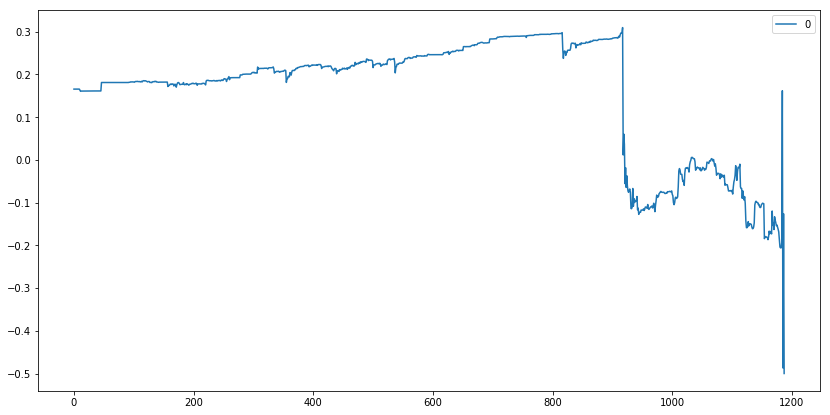

In [100]:
pd.DataFrame(mylist).plot()

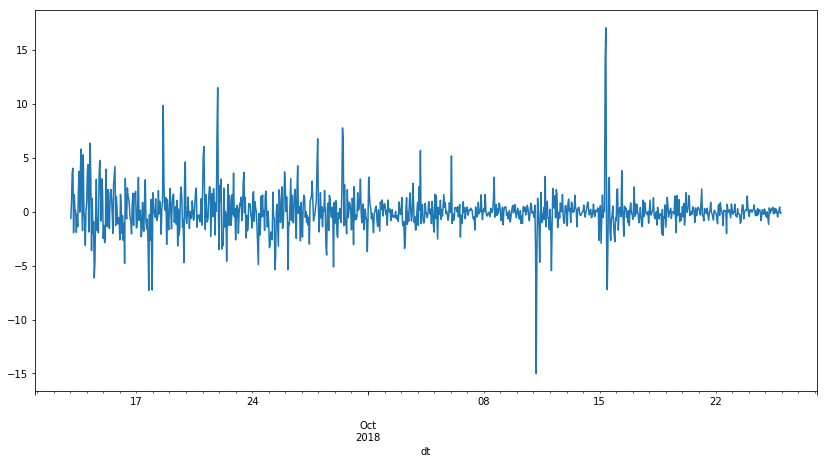

In [69]:
hist['2018-9-13':'2018-10-25'].price.diff().plot()